#Importing dependencies

In [0]:
import os
import cv2
import torch
import random
import numbers
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch import randperm
from torch._utils import _accumulate
import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as F
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import time
from skimage import io, transform
import sklearn.metrics as skm
import imutils
from scipy.spatial import distance

In [0]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Dataset preparation for Object Detection

In [0]:
class RobotDataset(Dataset):
    """Training the model with customized dataset.
    Args:
      root_dir: path where all the training files are saved.
      transform: transformations to be applied to the dataset.
      filenames: names of all the files in training dataset.
    """
    def __init__(self, root_dir, transform=None, filenames=None):
            
        self.root_dir = root_dir
        self.transform = transform
        self.filenames = filenames

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, ind):
        filepath =os.path.join(self.root_dir,self.filenames[ind])
        image = Image.open(filepath)
        if(filepath.endswith('.jpg')):
          xml_data = ET.parse(filepath.replace('.jpg','.xml')).getroot()
        elif(filepath.endswith('.png')):
          xml_data = ET.parse(filepath.replace('.png','.xml')).getroot()   
        all_dtls= []
        
        for group in xml_data.findall('object'):
            bndvalues = group.find('bndbox')
            all_dtls.append(find_bound_details(bndvalues))       
        sample = {'image': image, 'dtls': all_dtls}
        if self.transform:
            if type(self.transform) is not list:
              self.transform = [self.transform]
            for idx in range(len(self.transform)):
                  sample = self.transform[idx](sample)
        size = sample['image'].shape
        heatmap_list = torch.zeros([3,int(size[1]/4),int(size[2]/4)])
        i=0
        for group in xml_data.findall('object'):
            label = group.find('name').text
            img_heatmap = HeatMap(sample['dtls'][i],(size[1],size[2]))
            if(label == 'robot'):
               heatmap_list[0] += img_heatmap
            elif (label == 'goalpost'):
               heatmap_list[1] += img_heatmap 
            elif (label == 'ball'):
               heatmap_list[2] += img_heatmap  
            i+=1  
        dataset = {'image': sample['image'], 'heatmap': heatmap_list}

        return dataset

In [0]:
class TestDataset(Dataset):

    """Testing the model with customized dataset.

    Args:
        root_dir: path where all the training files are saved.
        transform: transformations to be applied to the dataset.
        filenames: names of all the files in training dataset.
        
    """
    def __init__(self, root_dir, transform=None, filenames=None):
            
        self.root_dir = root_dir
        self.transform = transform
        self.filenames = filenames
        
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, ind):
        filepath =os.path.join(self.root_dir,self.filenames[ind])
        image = Image.open(filepath)
        xml_data = ET.parse(filepath.replace('png','xml')).getroot()
        robot_dtls = np.zeros((3,4,2))
        goalpost_dtls = np.zeros((3,4,2))
        ball_dtls = np.zeros((2,4,2))
        
        robot_idx = 0
        goalpost_idx = 0
        ball_idx = 0
        
        for group in xml_data.findall('object'):
            bndvalues = group.find('bndbox')
            label = group.find('name').text
            if(label == 'robot' and robot_idx < 3):
              robot_dtls[robot_idx] = find_bound_details(bndvalues)
              robot_idx += 1
            elif(label == 'goalpost' and goalpost_idx < 3):
              goalpost_dtls[goalpost_idx] = find_bound_details(bndvalues)
              goalpost_idx += 1
            elif(label == 'ball' and ball_idx < 2):
              ball_dtls[ball_idx] = find_bound_details(bndvalues)
              ball_idx += 1
        sample = {'image': image, 
                  'robot_dtls': robot_dtls,
                  'goalpost_dtls':goalpost_dtls,
                  'ball_dtls':ball_dtls,
                  }
        if self.transform:
          if type(self.transform) is not list:
              self.transform = [self.transform]
          for idx in range(len(self.transform)):
              sample = self.transform[idx](sample)
        
        return sample


#Custom Dataset Preparation for Segmentation

In [0]:
class CustomDataset(Dataset):

  def __init__(self, image_paths, target_paths):

      self.image_paths = image_paths
      self.target_paths = target_paths
      
      
      self.transform = transforms.ToTensor()
                  
      self.mapping = {
            0: 0,
            2: 1,
            3: 2,
            1: 1              
        }
    
  def mask_to_class(self, mask):
    for k in self.mapping:
        mask[mask==k] = self.mapping[k]
    return mask
    
  def __getitem__(self, index):

    image = Image.open(self.image_paths[index])
    mask = Image.open(self.target_paths[index])
    
    t_image = self.transform(image) # transform to tensor for image
    #mask = self.transform(mask) # transform to tensor for mask

        
    mask = torch.from_numpy(np.array(mask, dtype=np.uint8)) 
    mask = self.mask_to_class(mask)
    mask = mask.long()

    return t_image, mask 

  def __len__(self):  # return count of sample we have

    return len(self.image_paths)


#Defining the transformation functions.

In [0]:
class transformed_ToTensor(object):
    """Convert ndarrays or PIL image in sample to Tensors."""
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W

    def __call__(self, sample):
      items = dict()
      for key in sample.keys():
          if key == 'image':
            image = sample[key]
            image = F.to_tensor(image)
            items[key] = image
          else:
            dtls = torch.FloatTensor(sample[key])
            items[key] = dtls
      return items

In [0]:
class transformed_Rescale(object):
    """
    Rescale the object to the size of given in output_size
    Args:
    output_size (tensor): required size of the output image
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        items = dict()
        image = sample['image']
        w, h = image.size
        if isinstance(self.output_size, int):
           if h > w:
              new_h, new_w = self.output_size * h / w, self.output_size
           else:
              new_h, new_w = self.output_size, self.output_size * w / h
        else:
           new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        for key in sample.keys():
          if key == 'image':
              img = F.resize(image, (new_h, new_w))
              items[key] = img
          else:
              all_dtls = sample[key]
              
              for i, dtls in enumerate(all_dtls):
                  all_dtls[i][0] = np.round(dtls[0] * np.array([new_w / w, new_h / h]), 0)
                  all_dtls[i][1] = np.round(dtls[1] * np.array([new_w / w, new_h / h]), 0)
                  all_dtls[i][3] = np.abs([dtls[0, 0]-dtls[1, 0], dtls[0, 1]-dtls[1, 1]])
                  all_dtls[i][2] = np.array([dtls[0, 0]+dtls[3, 0]/2, dtls[0, 1]+dtls[3, 1]/2])

              items[key] = all_dtls
              
        return items

In [0]:
class transformed_RandomHorizontalFlip(object):
    """
    Horizontally flip the given PIL Image randomly with a given probability.

    Args:
    p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
      items = dict()
      image = sample['image']
      w, h = image.size
      
      if random.random() < self.p:
          for key in sample.keys():
             if(key == 'image'):  
                image = F.hflip(image)
                items[key] = image
             else:
                all_dtls = sample[key]
              
                for i, dtls in enumerate(all_dtls):
                   if dtls[2][0] > 0 and dtls[2][1] > 0:
                      dtls[0][0] = w-1-dtls[0][0]-dtls[3][0]
                      dtls[1][0] = w-1-dtls[1][0]+dtls[3][0]
                      dtls[2][0] = w-1-dtls[2][0]

                items[key] = all_dtls
      else:
         return sample
      return items

In [0]:
class transformed_Normalize(object):
    """Normalize the image using mean and standard deviation provided.

    Args:
    mean(tensor): Mean of the guassian distribution to be used for normalization in 
    each dimension of the image.
    std: Standard deviation of the guassian distribution to be used for normalization in 
    each dimension of the image.
    """
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        """ 
        Normalizes the image in each dimension as per the mean and std values.      
        """
        items = dict()
        for key in sample.keys():
          if key == 'image':
            image = sample[key]
            items[key] = F.normalize(image, self.mean, self.std)
          else:
            items[key] = sample[key]
        return items

In [0]:
class Lambda(object):
    """Apply a user-defined lambda as a transform.

    Args:
    lambd (function): Lambda/function to be used for transform.
    """

    def __init__(self, lambd):
        assert callable(lambd), repr(type(lambd).__name__) + \
            " object is not callable"
        self.lambd = lambd

    def __call__(self, img):
        return self.lambd(img)

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [0]:
class transformed_ColorJitter(object):
    """Randomly change the brightness, contrast and saturation of an image.

    Args:
        brightness (float or tuple of float (min, max)): How much to jitter brightness.
            brightness_factor is chosen uniformly from [max(0, 1 - brightness), 1 + brightness]
            or the given [min, max]. Should be non negative numbers.
        contrast (float or tuple of float (min, max)): How much to jitter contrast.
            contrast_factor is chosen uniformly from [max(0, 1 - contrast), 1 + contrast]
            or the given [min, max]. Should be non negative numbers.
        saturation (float or tuple of float (min, max)): How much to jitter saturation.
            saturation_factor is chosen uniformly from [max(0, 1 - saturation), 1 + saturation]
            or the given [min, max]. Should be non negative numbers.
        hue (float or tuple of float (min, max)): How much to jitter hue.
            hue_factor is chosen uniformly from [-hue, hue] or the given [min, max].
            Should have 0<= hue <= 0.5 or -0.5 <= min <= max <= 0.5.
    """

    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = self._check_input(brightness, 'brightness')
        self.contrast = self._check_input(contrast, 'contrast')
        self.saturation = self._check_input(saturation, 'saturation')
        self.hue = self._check_input(hue, 'hue', center=0, bound=(-0.5, 0.5),
                                     clip_first_on_zero=False)

    def _check_input(self, value, name, center=1, bound=(0, float('inf')), clip_first_on_zero=True):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError(
                    "If {} is a single number, it must be non negative.".format(name))
            value = [center - value, center + value]
            if clip_first_on_zero:
                value[0] = max(value[0], 0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError(
                    "{} values should be between {}".format(name, bound))
        else:
            raise TypeError(
                "{} should be a single number or a list/tuple with lenght 2.".format(name))

        # if value is 0 or (1., 1.) for brightness/contrast/saturation
        # or (0., 0.) for hue, do nothing
        if value[0] == value[1] == center:
            value = None
        return value

    @staticmethod
    def get_params(brightness, contrast, saturation, hue):
        """Get a randomized transform to be applied on image.

        Arguments are same as that of __init__.

        Returns:
            Transform which randomly adjusts brightness, contrast and
            saturation in a random order.
        """
        tforms = []

        if brightness is not None:
            brightness_factor = random.uniform(brightness[0], brightness[1])
            tforms.append(
                Lambda(lambda img: F.adjust_brightness(img, brightness_factor)))

        if contrast is not None:
            contrast_factor = random.uniform(contrast[0], contrast[1])
            tforms.append(
                Lambda(lambda img: F.adjust_contrast(img, contrast_factor)))

        if saturation is not None:
            saturation_factor = random.uniform(saturation[0], saturation[1])
            tforms.append(
                Lambda(lambda img: F.adjust_saturation(img, saturation_factor)))

        if hue is not None:
            hue_factor = random.uniform(hue[0], hue[1])
            tforms.append(Lambda(lambda img: F.adjust_hue(img, hue_factor)))

        random.shuffle(tforms)
        transform = transforms.Compose(tforms)

        return transform

    def __call__(self, sample):
        """
        Args:
            sample (List): List of Input image and bounding box

        Returns:
            List: Color jittered image and original bounding box.
        """
        items = dict()
        for key in sample.keys():
          if key == 'image':
            image = sample[key]
            transform = self.get_params(self.brightness, self.contrast,
                                    self.saturation, self.hue)
            items[key] =  transform(image)
          else:
            items[key] = sample[key]
        return items


In [0]:
def find_bound_details(bndvalues):
   """ Finding details of boundary box from xml tag.
   Args:
   bndvalues: boundary details of the bounding box.
    
   Returns:
   corners of boundary box, center of the box, height and width as a array.
   """
   xmin = int(bndvalues.find('xmin').text)
   ymin = int(bndvalues.find('ymin').text)
   xmax = int(bndvalues.find('xmax').text)
   ymax = int(bndvalues.find('ymax').text)
   return np.array((xmin,ymin,xmax,ymax,(xmin+xmax)/2,(ymin+ymax)/2,np.abs(xmax-xmin),np.abs(ymin-ymax))).reshape(-1,2)

In [0]:
def bound_details_new(bnddtls,scaling):
    """ 
    Calculating the scaled boundary details
    Args:
    bnddtls: actual details of the boundary box
    scaling: scaling factor to change the details of boundary box
    Returns:
    scaled boundary box details
    """
    bnddtls[0] = bnddtls[0]/scaling
    bnddtls[1] = bnddtls[1]/scaling
    bnddtls[2][0] = (bnddtls[0, 0]+bnddtls[1, 0]) /2.0
    bnddtls[2][1] = (bnddtls[0, 1]+bnddtls[1, 1])/2.0
    bnddtls[3][0] = torch.abs(bnddtls[0, 0]-bnddtls[1, 0])
    bnddtls[3][1] = torch.abs(bnddtls[0, 1]-bnddtls[1, 1])
    return bnddtls

In [0]:
def HeatMap(bnddtls,filesize):
    """ 
    Generating heatmap based on boundary details
    Args:
    bnddtls: actual details of the boundary box
    filesize: size of the boundary box

    Returns:
    heat-map of size filesize/4 with center from bnddtls
    """
    bnddtls.float()
    bnddtls = bound_details_new(bnddtls,4.0)
    img_heatmap = torch.zeros(int(filesize[0]/4),int(filesize[1]/4))
    size=8
    kernel = cv2.getGaussianKernel(size, 8)
    kernel = np.dot(kernel, kernel.T)
    kernel *= 100
  
    if bnddtls[2][1].item()+size > img_heatmap.shape[0]-1:
                y_begin = img_heatmap.shape[0]-1-size
    else:
                y_begin = int(bnddtls[2][1].item())

    if bnddtls[2][0].item()+size > img_heatmap.shape[1]-1:
                x_begin = img_heatmap.shape[1]-1-size
    else:
                x_begin = int(bnddtls[2][0].item())

    y_end = y_begin + (size)
    x_end = x_begin + (size)
    img_heatmap[y_begin : y_end, x_begin : x_end] = torch.from_numpy(kernel)
    return img_heatmap

In [0]:
def HeatMap_circular(bnddtls,filesize, size=12):
    """ 
    Generating heatmap based on boundary details
    Args:
    bnddtls: actual details of the boundary box
    filesize: size of the boundary box
    size: size of the gaussian blob to be shown on heatmap.

    Returns:
    heat-map with gaussian blobs of size filesize/4 with center from bnddtls
    """
    bnddtls.float()
    bnddtls = bound_details_new(bnddtls,4.0)
    img_heatmap = torch.zeros(int(filesize[0]/4),int(filesize[1]/4))
    bnd = bnddtls.cpu().detach().numpy()
    if (not np.any(bnd)) == True:
      return img_heatmap

    size=size*3
    sigma = 2
    if (size == 36):
      sigma = 3
    kernel = cv2.getGaussianKernel(sigma = sigma, ksize = size)
    kernel = np.dot(kernel, kernel.T)
    kernel *= 100
    if bnddtls[2][1].item()+size > img_heatmap.shape[0]-1:
      y_begin = int(img_heatmap.shape[0]-1-size)
    elif bnddtls[2][1].item()-1-size < 0:
      y_begin = int(bnddtls[2][1].item())
    else:
      y_begin = int(bnddtls[2][1].item()-1-size/2)

    if bnddtls[2][0].item()+size > img_heatmap.shape[1]-1:
      x_begin = int(img_heatmap.shape[1]-1-size)
    elif bnddtls[2][0].item()-1-size < 0:
      x_begin = int(bnddtls[2][0].item())
    else:
      x_begin = int(bnddtls[2][0].item()-1-size/2)

    y_end = y_begin + (size)
    x_end = x_begin + (size)
    mult = 1
    if (size == 36):
      mult = 5000
    img_heatmap[y_begin : y_end, x_begin : x_end] = mult*torch.from_numpy(kernel)
    return img_heatmap

#Pre-Processing for Segmentation

In [0]:
from PIL import Image
import os
import sys

directory = "/content/drive/My Drive/segmentation2/dataset/image"

for file_name in os.listdir(directory):
  
  image = Image.open(os.path.join(directory, file_name))
  

  x,y = image.size
  if (x != 640 or y != 480):
      print("Processing %s" % file_name)
      new_dimensions = (640,480)
      output = image.resize(new_dimensions, Image.ANTIALIAS)

      output_file_name = os.path.join(directory,file_name)
      output.save(output_file_name, "JPEG", quality = 95)

print("All done")

Processing output_R2017HAFNvsS_0196.jpg
Processing bneb_euro_ball_01_d_00291.jpg
Processing bs04_leipzig_robocup16_000.040.jpg
Processing output_NTR2017QV_0077.jpg
Processing output_R2016HTSWN_0099_copy.jpg
Processing bnebg_euro_ball_game_1_d_00201.jpg
Processing bs09_leipzig_robocup16_004.830.jpg
Processing bnebg_euro_ball_game_1_d_00271.jpg
Processing bneb_euro_ball_01_a_00151.jpg
Processing bs06_leipzig_robocup16_002.350.jpg
Processing bs01_jan16_seq__000.311.jpg
Processing bs04_leipzig_robocup16_000.640.jpg
Processing bneb_euro_ball_01_j_00091.jpg
Processing bs04_leipzig_robocup16_euroball480.jpg
Processing bs04_leipzig_robocup16_000.150.jpg
Processing bs13_leipzig_robocup16_009.420.jpg
Processing bnebg_euro_ball_game_1_h_00161.jpg
Processing bs03_leipzig_robocup16_000.301.jpg
Processing output_R2017ARRNvsCB_0017_copy.jpg
Processing bs11_leipzig_robocup16_007.610.jpg
Processing bs03_leipzig_robocup16_000.381.jpg
Processing bs11_leipzig_robocup16_007.620.jpg
Processing bs13_leipzig_

In [0]:
from PIL import Image
import os
import sys
count = 0
directory = "/content/drive/My Drive/segmentation2/dataset/target"

for file_name in os.listdir(directory):
  print("Processing %s" % file_name)
  image = Image.open(os.path.join(directory, file_name))

  x,y = image.size
  #if (x == 640 and y == 480):
  new_dimensions = (160,120)
  output = image.resize(new_dimensions, Image.ANTIALIAS)

  output_file_name = os.path.join(directory,file_name)
  output.save(output_file_name, "PNG", quality = 95)
  count = count + 1
print("All done")
print(count)

Processing bs04_leipzig_robocup16_euroball480.png
Processing bs15_leipzig_robocup16_011.210.png
Processing 2019-06-19-10-55-51.png
Processing opx_frame001860.png
Processing opx_frame004275.png
Processing opx_frame003305.png
Processing opx_frame004160.png
Processing opx_frame001385.png
Processing opx_frame004630.png
Processing opx_frame004385.png
Processing opx_frame002690.png
Processing opx_frame001160.png
Processing opx_frame000850.png
Processing opx_frame001350.png
Processing opx_frame003550.png
Processing opx_frame001010.png
Processing bs04_leipzig_robocup16_000.110.png
Processing opx_frame005420.png
Processing opx_frame003150.png
Processing opx_frame002135.png
Processing opx_frame004305.png
Processing opx_frame003590.png
Processing opx_frame002055.png
Processing opx_frame004395.png
Processing opx_frame002815.png
Processing opx_frame002890.png
Processing opx_frame004095.png
Processing opx_frame004650.png
Processing opx_frame004840.png
Processing 2019-06-19-10-54-47.png
Processing op

#Loading the dataset and applying transforms for detection

# Randomly splitting the training and testing data for Detection

In [0]:
# Randomly splitting the training and testing data.

full_dataset_dir = "/content/drive/My Drive/dataset2"
filenames = []
for file in os.listdir(full_dataset_dir):
    if file.endswith(".png"):
        filenames.append(file)
print(filenames)
train_size = int(0.7 * len(filenames))
test_size = len(filenames) - train_size
train_data_list, test_data_list = torch.utils.data.random_split(filenames, [train_size, test_size])
print("Train list",list(train_data_list))
print("Test list",list(test_data_list))


['2019-06-21-14-18-01_.png', 'output_NTR2017QV_0075.png', 'bs10_leipzig_robocup16_006.500.png', 'bs07_leipzig_robocup16_003.010.png', 'bs09_leipzig_robocup16_004.720.png', 'bs02_jun16_seq_pos_000.911.png', 'bnebg_euro_ball_game_1_b_00331.png', 'output_R2017HLWNT_0055_copy.png', 'bneb_euro_ball_01_j_00161.png', 'bs09_leipzig_robocup16_004.740.png', 'bs01_img_fr_nov15_000.001.png', 'bnebg_euro_ball_game_1_g_00661.png', 'bneb_euro_ball_01_i_00051.png', 'bs08_leipzig_robocup16_003.720.png', 'bneb_euro_ball_01_b_00081.png', 'bs05_leipzig_robocup16_001.120.png', 'bnebg_euro_ball_game_1_h_00151.png', '2018-06-17-15-13-06_.png', 'bs07_leipzig_robocup16_003.090.png', 'bs13_leipzig_robocup16_009.290.png', 'output_R2016HTTGfN_0022_copy.png', 'bs05_leipzig_robocup16_000.900.png', 'bneb_euro_ball_01_c_00431.png', 'bnebg_euro_ball_game_1_h_00461.png', 'bs07_leipzig_robocup16_002.780.png', 'bneb_euro_ball_01_b_00281.png', '2018-06-17-19-33-41_.png', 'output_R2017HAFNvsS_0238.png', 'bneb_euro_ball_01_

In [0]:
# Transforming the training and test data.
transforms1 = [transformed_Rescale((480,640)), transformed_RandomHorizontalFlip(),
                transformed_ColorJitter(brightness=0.01, contrast=0.01, saturation=0.01),
                transformed_ToTensor(), transformed_Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
transforms2 = [transformed_Rescale((480,640)),transformed_ToTensor(), transformed_Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
train_dataset = RobotDataset(full_dataset_dir, transform=transforms1, filenames=list(train_data_list))
test_dataset = TestDataset(full_dataset_dir, transform=transforms2, filenames=list(test_data_list))


In [0]:
print("Train list",len(train_data_list))
print("Test list",len(test_data_list))

Train list 2510
Test list 1077


#Random split of Train and Test Dataset for Segmentation

In [0]:
import glob
folder_data = glob.glob("/content/drive/My Drive/segmentation2/dataset/image/*.jpg")
folder_mask = glob.glob("/content/drive/My Drive/segmentation2/dataset/target/*.png") 


folder_data.sort(key = len)
folder_mask.sort(key = len)
#print(folder_data)

len_data = len(folder_data)
print("count of dataset: ", len_data)

len_mask = len(folder_mask)
print("count of mask",len_mask)

assert len(folder_data) == len(folder_mask) 

indices = list(range(len(folder_data)))

random.shuffle(indices)

indices.copy()


image_indices = [folder_data[i] for i in indices]

mask_indices = [folder_mask[i] for i in indices]

split_1 = int(0.7 * len(image_indices))

folder_data.sort()

train_image_paths = image_indices[:split_1]
print("count of training images is: ", len(train_image_paths)) 
train_mask_paths = mask_indices[:split_1]
print("count of training mask is: ", len(train_image_paths)) 

test_image_paths = image_indices[split_1:]
print("count of test images is: ", len(test_image_paths))

test_mask_paths = mask_indices[split_1:]
print("count of test images is: ", len(test_mask_paths))




count of dataset:  1108
count of mask 1108
count of training images is:  775
count of training mask is:  775
count of test images is:  333
count of test images is:  333


#Train Loader and Test Loader for Object Detection.

In [0]:
#batch size
batch_size = 5

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

#Train Loader and Test Loader for segmentation.

In [0]:

train_dataset_seg = CustomDataset(train_image_paths, train_mask_paths)
train_loader_seg = torch.utils.data.DataLoader(train_dataset_seg, batch_size=1, shuffle=True)

test_dataset_seg = CustomDataset(test_image_paths, test_mask_paths)
test_loader_seg = torch.utils.data.DataLoader(train_dataset_seg, batch_size=1, shuffle=False)  



#Preparing the test image for visualization of segmentation

In [0]:
img_dir_test = ['/content/drive/My Drive/segmentation2/dataset/image/00213.jpg'] 
mask_dir_test = ['/content/drive/My Drive/segmentation2/dataset/target/00213.png']
test_dataset_seg = CustomDataset(img_dir_test,mask_dir_test)

test_loader_segmentation = torch.utils.data.DataLoader(test_dataset_seg,batch_size=1,shuffle=False)

In [0]:
#set device to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initializing the model and adding location dependent bias layer as the final layer


In [0]:

class LocationAwareConv2d(torch.nn.Conv2d):
    def __init__(self,gradient,w,h,in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.locationBias=torch.nn.Parameter(torch.zeros(w,h,3))
        self.locationEncode=torch.autograd.Variable(torch.ones(w,h,3))
        if gradient:
            for i in range(w):
                self.locationEncode[i,:,1]=self.locationEncode[:,i,0]=(i/float(w-1))
    def forward(self,inputs):
        if self.locationBias.device != inputs.device:
            self.locationBias=self.locationBias.to(inputs.get_device())
        if self.locationEncode.device != inputs.device:
            self.locationEncode=self.locationEncode.to(inputs.get_device())
        b=self.locationBias*self.locationEncode
        return super().forward(inputs)+b[:,:,0]+b[:,:,1]+b[:,:,2]

In [0]:
class myModel(nn.Module):
      
      def __init__(self):
        super(myModel,self).__init__()
        model_resnet = models.resnet18(pretrained=True)
        self.encoder_block1 = nn.Sequential(*list(model_resnet.children())[0:5])
        self.encoder_block2 = nn.Sequential(*list(model_resnet.children())[5:6])
        self.encoder_block3 = nn.Sequential(*list(model_resnet.children())[6:7])
        self.encoder_block4 = nn.Sequential(*list(model_resnet.children())[7:-2])
         
        self.decoder_block1 = nn.Sequential(
                        nn.ReLU(),
                        nn.ConvTranspose2d(512,256,2,2,0,output_padding = 0))
                             
        self.decoder_block2 = nn.Sequential(
                        nn.ReLU(),
                        nn.BatchNorm2d(512),
                        nn.ConvTranspose2d(512,256,2,2,0,output_padding = 0))
                        
        self.decoder_block3 = nn.Sequential(
                        nn.ReLU(),
                        nn.BatchNorm2d(512),
                        nn.ConvTranspose2d(512,128,2,2,0,output_padding = 0))
                        
        self.decoder_block4 = nn.Sequential(
                        nn.ReLU(),
                        nn.BatchNorm2d(256),
                        LocationAwareConv2d(True,120,160,256,3,1,1))
        
        self.conv1x1_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1)
        self.conv1x1_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1)
        self.conv1x1_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)
         
      

      def forward(self,x):
        out = self.encoder_block1(x) 
        residual1 = self.conv1x1_1(out) 
         
        out = self.encoder_block2(out)  
         
        residual2 = self.conv1x1_2(out)
         
        out = self.encoder_block3(out) 
         
        residual3 = self.conv1x1_3(out) 
        out = self.encoder_block4(out) 
        
        out = self.decoder_block1(out) 
        
        
        decoder_block2_input = torch.cat((out,residual3), 1) 
        
        out = self.decoder_block2(decoder_block2_input)
        
        decoder_block3_input = torch.cat((out,residual2),1) 
        
        out = self.decoder_block3(decoder_block3_input) 
        decoder_block4_input = torch.cat((out,residual1),1) 
        out = self.decoder_block4(decoder_block4_input) 
        
        return out


In [0]:
#to instantiate and use the model
model = myModel()
model.to(device)

#Using Mean-Squared error Loss Function for detection
criterion = nn.MSELoss()
criterion.to(device)

#Negative Log Likelihood Loss Function for Segmentation
criterion1 = nn.CrossEntropyLoss()
criterion1.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


CrossEntropyLoss()

In [0]:
#Optimizer intialization
optimizer = optim.Adam([
                        {"params":model.encoder_block1.parameters(), "lr": 0.0001},
                        {"params":model.encoder_block2.parameters(), "lr": 0.0001},
                        {"params":model.encoder_block3.parameters(), "lr": 0.0001},
                        {"params":model.encoder_block4.parameters(), "lr": 0.0001},
                        {"params":model.decoder_block1.parameters()},
                        {"params":model.decoder_block2.parameters()},
                        {"params":model.decoder_block3.parameters()},
                        {"params":model.decoder_block4.parameters()},
                        {"params":model.conv1x1_1.parameters()},
                        {"params":model.conv1x1_2.parameters()},
                        {"params":model.conv1x1_3.parameters()}], lr=0.01)

#Training the model

In [0]:
def train_detection(model,train_loader, criterion, optimizer):
      """
        Function used to train the model
        Args:
          model: Model which is to be trained.
          train_loader: Batched dataset used to train the model.
          criterion: Criterion used to train the model.
          optimizer: optimizer used for the model.
      """      
      
      model.train()
      train_loss = 0.0
      for i_batch, sample_batched in enumerate(train_loader):
          
          image = sample_batched['image'].to(device)
          heatmap = sample_batched['heatmap'].to(device) 
          
          output = model(image)
          optimizer.zero_grad()
          loss = criterion(output, heatmap)
          train_loss += loss
          loss.backward()  
          optimizer.step()
          
      return train_loss.item(), model


In [0]:


def train_segmentation(model,train_loader_segmentation, criterion, optimizer):
      """
        Function used to train the model
        Args:
          model: Model which is to be trained.
          train_loader: Batched dataset used to train the model.
          criterion: Criterion used to train the model.
          optimizer: optimizer used for the model.
      """      
      
      model.train()
      train_loss = 0.0
      for i_batch, data in enumerate(train_loader_segmentation):
          t_image, mask = data
          t_image, mask = t_image.to(device), mask.to(device)
          
          output = model(t_image)
          optimizer.zero_grad()
         
          loss = criterion1(output,mask)
          train_loss += loss/20
          loss.backward()  
          optimizer.step()
          
      return train_loss.item(), model

In [0]:
# Training the segmentation and detection model alternately using different data loaders and criterions.
total_loss = 0.0
loss_details = [None]*500

for epoch in range(50):
    
    print("epoch",epoch)
    if(epoch%2 == 0):
      train_loss_, model = train_segmentation(model,train_loader_seg, criterion1, optimizer)
      loss_details[epoch] = train_loss_
    else:
      train_loss_, model = train_detection(model,train_loader, criterion, optimizer)
      loss_details[epoch] = train_loss_
    print("train loss",train_loss_)
    total_loss += train_loss_
    print("total loss", total_loss)

epoch 0
train loss 16.959819793701172
total loss 16.959819793701172
epoch 1
train loss 14.853872299194336
total loss 31.813692092895508
epoch 2
train loss 16.737510681152344
total loss 48.55120277404785
epoch 3
train loss 15.27641773223877
total loss 63.82762050628662
epoch 4
train loss 16.346216201782227
total loss 80.17383670806885
epoch 5
train loss 17.72555160522461
total loss 97.89938831329346
epoch 6
train loss 15.834840774536133
total loss 113.73422908782959
epoch 7
train loss 16.93287467956543
total loss 130.66710376739502
epoch 8
train loss 15.179779052734375
total loss 145.8468828201294
epoch 9
train loss 23.20118522644043
total loss 169.04806804656982
epoch 10
train loss 14.033886909484863
total loss 183.0819549560547
epoch 11
train loss 43.6439094543457
total loss 226.7258644104004
epoch 12
train loss 13.206436157226562
total loss 239.93230056762695
epoch 13
train loss 18.922025680541992
total loss 258.85432624816895
epoch 14
train loss 12.428106307983398
total loss 271.282

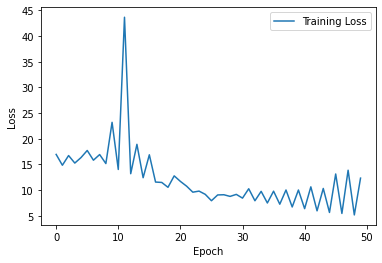

In [0]:
#plot the learning curve
plt.plot(range(len(loss_details)),loss_details, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Save and load the model

In [0]:
path = '/content/drive/My Drive/combined_model_Fulldata_epoch50alternate.pth'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': loss_details,
            }, path)

In [0]:
model = myModel()
optimizer = optimizer
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss_1 = checkpoint['train_loss']
model.to(device)
model.train()

#Testing the Object detection model

1.  Calculate the center of the contour
2.  Post process function to calculate the metrics 


 

In [0]:
def center_of_shape(image):
  """
  To find centers of the contours in the input image.
  
  Args:
  image: Image of which we want to find the contours.
  
  Returns: Array of centers of all the contours in the input image.
  """
  out_centers = []
  blurred = cv2.GaussianBlur(image, (3, 3), 0)
  thresh = cv2.threshold(blurred,0.1, 255, cv2.THRESH_BINARY)[1]
  cnts = cv2.findContours(thresh.copy().astype(np.uint8), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  for c in cnts:
    M = cv2.moments(c)
    if(M["m00"]>0):
      cX = int(M["m10"] / M["m00"])
      cY = int(M["m01"] / M["m00"])
      out_centers.append((cX,cY))
  
  return torch.FloatTensor(out_centers)

In [0]:
def post_process(tensor, out, allowed_distance):
  """
  Determinining if the output from the model are contributing to true positive,
  false negative, false positive or true negative.
  
  Args: 
  Tensor: Boundary box details from the test dataset.
  out: Centers of output details from the contour from output of the model.
  allowed_distance: acceptable distance between boundary box center and output center.
  returns:
  Number of True Positive, False Negative, False postives and True Negative.
  
  """
  l_b = 0
  l_o = len(out)
  
  TruePositive = 0
  FalseNegative = 0
  FalsePositive = 0
  TrueNegative = 0
  correct = 0
  for i in range(tensor.size(0)):
    if(tensor[i][2][0]>0 or tensor[i][2][1]>0):
      l_b +=1
  
  flag = np.zeros(l_b)
  for k in range(l_o):
    found = -1
    for l in range(l_b):
      Boundary_center = tensor[l][2]/4.0
      object_detected = False
      out_center = out[k]
      if out_center[0]>0 or out_center[1]>0:
        object_detected = True
       
      if object_detected:
        dist = distance.euclidean(Boundary_center.cpu(),out_center.cpu()) 
        if dist <= allowed_distance:  
          TruePositive +=1
          found = l
          break
    if found == -1:
      FalsePositive += 1
    else:
      flag[found] = 1
  if len(out) == 0 and (not np.any(tensor.cpu().detach().numpy())) == True:
    TrueNegative += 1
  FalseNegative = np.count_nonzero(flag == 0)
  return TruePositive,FalseNegative,FalsePositive,TrueNegative

In [0]:
#Testing the model with distance of 4 pixels.

model.eval()
test_data_len = len(test_dataset)
correct = 0
test_loss = 0
total = 0
Recall = torch.zeros(3)
TruePositive = torch.zeros(3)
FalsePositive = torch.zeros(3)
FalseNegative = torch.zeros(3)
TrueNegative = torch.zeros(3)
FDR = torch.zeros(3)
precision = torch.zeros(3)
F1_score  = torch.zeros(3)
acc = torch.zeros(len(test_loader))
accuracy = torch.zeros(3)
image_final = None
heatmap_list = torch.zeros([3,120,160])
count = 0
for j,test_data in enumerate(test_loader):
      
    images = test_data['image'].to(device)
    size = test_data['image'].shape

    robot_dtls = test_data['robot_dtls'].to(device)
    goalpost_dtls = test_data['goalpost_dtls'].to(device)
    ball_dtls = test_data['ball_dtls'].to(device)
    images.requires_grad_(False)
    robot_dtls.requires_grad_(False)
    goalpost_dtls.requires_grad_(False)
    ball_dtls.requires_grad_(False)
    outputs = model(images)
    batch_size = outputs.shape[0]
    
    for i in range(batch_size):
      out_center1 = center_of_shape(outputs[i][0].cpu().detach().numpy())
      tp,fn,fp,tn = post_process(robot_dtls[i],out_center1,4)

      TruePositive[0] += tp
      FalseNegative[0] += fn
      FalsePositive[0]  += fp
      TrueNegative[0] += tn
      
      out_center2 = center_of_shape(outputs[i][1].cpu().detach().numpy())
      tp,fn,fp,tn = post_process(goalpost_dtls[i],out_center2,4)
      TruePositive[1] += tp
      FalseNegative[1] += fn
      FalsePositive[1]  += fp
      TrueNegative[1] += tn

      out_center3 = center_of_shape(outputs[i][2].cpu().detach().numpy())
      tp,fn,fp,tn = post_process(ball_dtls[i],out_center3,4)
      
      
      TruePositive[2] += tp
      FalseNegative[2] += fn
      FalsePositive[2]  += fp
      TrueNegative[2] += tn

      if (count == 0):
            image = images[i].cpu().detach().numpy()
            image_final = image
            for k in range(robot_dtls[i].size()[0]):
              img_heatmap = HeatMap_circular(robot_dtls[i][k],(size[2],size[3]),12)
              heatmap_list[0] += img_heatmap
            for k in range(goalpost_dtls[i].size()[0]):
              img_heatmap = HeatMap_circular(goalpost_dtls[i][k],(size[2],size[3]),6)
              heatmap_list[1] += img_heatmap
            for k in range(ball_dtls[i].size()[0]):
              img_heatmap = HeatMap_circular(ball_dtls[i][k],(size[2],size[3]),6)
              heatmap_list[2] += img_heatmap
            count = count + 1

for i in range(3):
    accuracy[i] = TruePositive[i]+TrueNegative[i]/ (TruePositive[i]+TrueNegative[i]+FalsePositive[i]+FalseNegative[i])

    Recall[i] = (TruePositive[i])/(TruePositive[i]+FalseNegative[i])
    FDR[i] = (FalsePositive[i])/(FalsePositive[i]+TruePositive[i])
    precision[i] = TruePositive[i]/(TruePositive[i] + FalsePositive[i])
    F1_score[i]  = (2*precision[i]*Recall[i])/(precision[i]+Recall[i])

print("Recall of Robot "+str(round(float(Recall[0]),2)) )
print("Recall of Goalpost "+str(round(float(Recall[1] ),2)))
print("Recall of Ball "+str(round(float(Recall[2]),2)) )

print("\nAccuracy of Robot "+str(round(float(accuracy[0] ),2)))
print("Accuracy of Goalpost "+str(round(float(accuracy[1]),2)) )
print("Accuracy of Ball "+str(round(float(accuracy[2]),2)) )

print("\nFDR of Robot "+str(round(float(FDR[0] ),2)))
print("FDR of Goalpost "+str(round(float(FDR[1]),2)) )
print("FDR of Ball "+str(round(float(FDR[2]),2)) )

print("\nPrecision of Robot "+str(round(float(precision[0] ),2)))
print("Precision of Goalpost "+str(round(float(precision[1]),2)) )
print("Precision of Ball "+str(round(float(precision[2]),2)) )

print("\nF1_score of Robot "+str(round(float(F1_score[0] ),2)))
print("F1_score of Goalpost "+str(round(float(F1_score[1]),2)) )
print("F1_score of Ball "+str(round(float(F1_score[2]),2)) )


Total_recall = torch.mean(Recall)
Total_accuracy = torch.mean(accuracy)
Total_FDR = torch.mean(FDR)
Total_precision = torch.mean(precision)
Total_F1_score = torch.mean(F1_score)
print("\nTotal recall "  +str(round(float(Total_recall),2)))
print("Total accuracy "  +str(round(float(Total_accuracy),2)))
print("Total FDR "  +str(round(float(Total_FDR),2)))
print("Total precision "  +str(round(float(Total_precision),2)))
print("F1_score " +str(round(float(Total_F1_score),2)))

Recall of Robot 0.54
Recall of Goalpost 0.56
Recall of Ball 0.73

Accuracy of Robot 0.29
Accuracy of Goalpost 0.88
Accuracy of Ball 0.77

FDR of Robot 0.95
FDR of Goalpost 0.93
FDR of Ball 0.76

Precision of Robot 0.54
Precision of Goalpost 0.56
Precision of Ball 0.73

F1_score of Robot 0.54
F1_score of Goalpost 0.56
F1_score of Ball 0.73

Total recall 0.61
Total accuracy 0.65
Total FDR 0.88
Total precision 0.61
F1_score 0.61


#Object detection test heatmaps

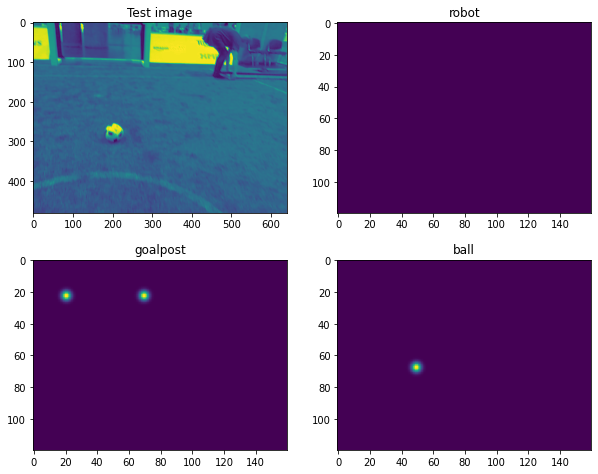

In [0]:
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
plt.title('Test image')
plt.imshow(image_final[0])
plt.subplot(2,2,2)
plt.title('robot')
plt.imshow(heatmap_list[0])
plt.subplot(2,2,3)
plt.title('goalpost')
plt.imshow(heatmap_list[1])
plt.subplot(2,2,4)
plt.title('ball')
plt.imshow(heatmap_list[2])
plt.show()

#Segmentation Results

Segmentation result of the model

torch.Size([1, 3, 120, 160])
torch.Size([1, 120, 160])
torch.Size([1, 120, 160])


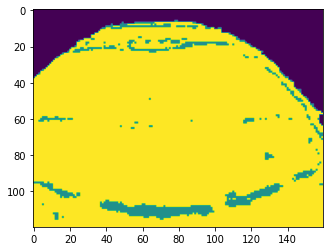

In [0]:
for i, (inputs, targets) in enumerate(test_loader_segmentation):
  with torch.no_grad():
    inputs = inputs.to(device)
    targets = targets.to(device)
    outputs = model(inputs)
    print(outputs.size())
    _, pred = torch.max(outputs, dim=1)
    print(pred.size())
    pred_tensor = pred
    print(pred_tensor.size())
    pred_tensor = pred_tensor.squeeze()
    plt.imshow(pred_tensor.cpu())


Input image for the above result

torch.Size([3, 480, 640])
torch.Size([1, 120, 160])


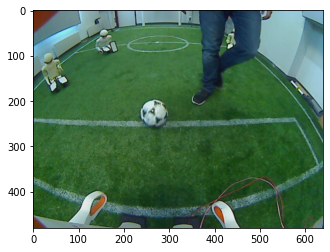

In [0]:
for i, (inputs, targets) in enumerate(test_loader_segmentation):
  inputs = inputs.to(device)
  
  inputs = inputs.squeeze()
  print(inputs.size())
  targets = targets.to(device)
  print(targets.size())
  plt.imshow(inputs.permute(1,2,0).cpu())


#IOU Implementation

In [0]:
import torch
import numpy as np 


# PyTroch version

SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  
    union = (outputs | labels).float().sum((1, 2))         
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
   
    
    return iou.mean(), intersection.mean(),union.mean()  
    

# Calculating Overall pixel accuracy and IOU

In [0]:
preds = []
labels = []
ious = []

for i, (image, target) in enumerate(test_loader):
  with torch.no_grad():
    image = image.to(device)
    target = target.to(device)
    output = model(image)

    _, pred = torch.max(outputs, dim=1)

    labels.append(target.data)
    preds.append(pred.data)
    iou,intersect,union = iou_pytorch(output.byte(),target.byte())
    ious.append(iou)

preds = torch.cat(preds,dim=0)
labels = torch.cat(labels,dim = 0)
acc = preds.eq(labels).float().mean().cpu()
ious = np.asarray(ious, dtype=np.float32)  

In [0]:
acc

tensor(74.0911)

In [0]:
ious.mean()

array(0.46)